# Heat Isochrones Calculation for POIs

In [1]:
# Import necessary libraries
import geopandas as gpd
import pandas as pd
import openrouteservice as ors
from pathlib import Path
import pyogrio
import os
from shapely.geometry import Point, LineString, Polygon
from pyproj import Geod
import rasterio
import rasterio.warp
import numpy as np
from rasterstats import zonal_stats
import matplotlib.pyplot as plt
from matplotlib import style
from matplotlib.colors import ListedColormap

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
# Prepare the OpenRouteService client for HEAL-API requests
ors_url = "insert_HEAL_API-URL" # Contact the HeiGIT team or author of this repository to get access to the HEAL-API. More information in Readme.md

profile = "foot-walking"
fmt = 'geojson'
__headers = {"headers":{
            'Accept': 'application/json, application/geo+json, application/gpx+xml, img/png; charset=utf-8',
            'Content-Type': 'application/json; charset=utf-8'}}

client = ors.Client(base_url=ors_url)

In [4]:
# Define input parameters for Transport POIs
input_filename = 'transport_pois_hd_clipped.shp'
pois_name = 'transport'

# Define file path
filepath = f'{Path.cwd()}\data\\{input_filename}'

# Read the shapefile
points = gpd.read_file(filepath)   

# Access the geometry column to get the points
point_geometry = points.geometry

# Seperate the coordinates into a list
coordinates = [[point.x, point.y] for point in point_geometry]

# Print the number of points
print(f'Number of points: {len(coordinates)}')

Number of points: 614


In [5]:
# # Define input parameters essential OSM POIs under heat stress
# input_filename = 'pois_hd_clipped.shp'
# pois_category = 'supermarket' # can be 'clinic' , 'doctors' ,  'hospital' , 'kindergarten' ,  'pharmacy' ,  'supermarket'

# # Define file path
# filepath = f'{Path.cwd()}\data\\{input_filename}'

# # Read the shapefile
# pois = gpd.read_file(filepath)

# # Filter POIs based on the category
# if isinstance(pois_category, tuple):
#     # multiple categories
#     points = pois[pois['fclass'].isin(pois_category)]
#     pois_name = '_'.join(pois_category)
# else:
#     # single category
#     points = pois[pois['fclass'] == pois_category]
#     pois_name = pois_category

# # Access the geometry column to get the points
# point_geometry = points.geometry

# # Seperate the coordinates into a list
# coordinates = [[point.x, point.y] for point in point_geometry]

In [6]:
# # Define input parameters for Social Facility POIs
# input_filename = 'pois_hd_social_facility.shp'
# pois_name = 'social_facility'

# # Define file path
# filepath = f'{Path.cwd()}\data\\{input_filename}'

# # Read the shapefile
# points = gpd.read_file(filepath)   

# # Access the geometry column to get the points
# point_geometry = points.geometry

# # Seperate the coordinates into a list
# coordinates = [[point.x, point.y] for point in point_geometry]

In [7]:
# # Define input parameters for Kindergarten POIs
# input_filename = 'pois_hd_kinder_osm.shp'
# pois_name = 'kinder'

# # Define file path
# filepath = f'{Path.cwd()}\data\\{input_filename}'

# # Read the shapefile
# points = gpd.read_file(filepath)   

# # Access the geometry column to get the points
# point_geometry = points.geometry

# # Seperate the coordinates into a list
# coordinates = [[point.x, point.y] for point in point_geometry]

Define Function `get_isocalors` that returns the isochrones of a heat equation from the HEAL-API.

In [8]:
# define function to call isochrones from HEAL-API

def get_isocalors(coordinates, range_values, range_type, shadow_factor, timeofday):
  """
  Function to call isochrones from HEAL-API.

  Args:
    coordinates (str): The coordinates of the location.
    range_values (list): The range values for the isochrones.
    range_type (str): The type of range values (e.g., 'time', 'distance').
    shadow_factor (float): The shadow factor for the isochrones.
    timeofday (str): The time of day for the isochrones (e.g., 'morning', 'noon', 'afternoon', 'evening').

  Returns:
    dict: The response from the HEAL-API.

  """
  # Define the parameters for the API request
  params = {
    'locations': coordinates,
    'range': range_values,
    'range_type': range_type,
    "options": {
      "profile_params": {
        "weightings": {
          "csv_factor": shadow_factor,
          "csv_column": timeofday
        }
      }
    }
  }

  # Make the API request
  response = client.request(
    url="v2/isochrones/{}/{}".format(profile, fmt),
    post_json=params,
    requests_kwargs=__headers,
    get_params=[]
  )

  return response

Call function for various parameter sets

In [9]:
# Run the function for all coordinates and different time of day values and different shadow factors:
time_of_day_values = ['morning','noon','afternoon','evening'] # can be: morning, noon, afternoon, evening
shadow_factors = [0.0, 1.0, 2.0, 3.0, 4.0, 5.0] # range from 0.0 to 5.0 (0.0 = no influence of shadow-data, 1.0 - 5.0 = increasing heat sensibility)
range_vals = [[300],[600],[900],[1200],[1800]] # in seconds

# Create an empty GeoDataFrame to store the isochrones
isochrones_df = gpd.GeoDataFrame()

# Iterate over range values
for range_val in range_vals:
    # Iterate over the time of day values
    for timeod in time_of_day_values:
        # Iterate over the shadow factors
        for shadow_fact in shadow_factors:
            # Iterate over all POIs
            for c in coordinates:
                isochrones = get_isocalors([list(c)], range_val, 'time', shadow_fact, timeod)
                isochrones_df_temp = gpd.GeoDataFrame.from_features(isochrones, crs=points.crs)
                
                # Access for c corresponding osm_id, fclass, and name
                point_index = coordinates.index(c)
                osm_id = points.iloc[point_index]['osm_id'] if 'osm_id' in points.columns else np.nan
                fclass = points.iloc[point_index]['fclass'] if 'fclass' in points.columns else np.nan
                name = points.iloc[point_index]['name']
                
                # Add shadow factor and time of day, osm_id, fclass and name as columns
                isochrones_df_temp['shadow_factor'] = shadow_fact
                isochrones_df_temp['timeofday'] = timeod
                isochrones_df_temp['osm_id'] = osm_id
                isochrones_df_temp['fclass'] = fclass
                isochrones_df_temp['name'] = name
                isochrones_df_temp['start_point'] = [c]
                
                # Append the temporary GeoDataFrame to the main GeoDataFrame
                isochrones_df = isochrones_df.append(isochrones_df_temp, ignore_index=True)

Calculate the distance between central point of isochrone and start point

In [10]:
# Iterate over the rows of the GeoDataFrame
for index, row in isochrones_df.iterrows():
    # Get the osm_id and center point from the current row
    osm_id = row['osm_id']
    center_point = row['center']
    start_point = row['start_point']

    # Create Shapely point geometries
    center_geometry = Point(center_point[0], center_point[1])
    start_geometry = Point(start_point[0], start_point[1])

    # Create linestring from the center point to the reference point
    line = LineString([center_geometry, start_geometry])
    geod = Geod(ellps="WGS84")
    distance = geod.geometry_length(line)
    
    # Write the distance into the 'distance' column of the GeoDataFrame
    isochrones_df.at[index, 'distance_center_start_pt'] = distance

# Set geometry row
isochrones_df.set_geometry('geometry', inplace=True)

Calculate the population within the isochrone with Global Human Settlement Layer (GHSL) data

In [11]:
# Specify the path to the raster file
raster_file = f'{Path.cwd()}\\data\\GHS_POP_E2020_GLOBE_R2023A_54009_100_V1_0_R4_C19_reproj_UTM.tif'

# Read the population raster file
with rasterio.open(raster_file) as dataset:
    # Get the population data
    population_data = dataset.read(1)

# Initialize an empty list to store the population for each isochrone
population_values = []

# Reproject the isochrones to population raster CRS
isochrones_df = isochrones_df.to_crs(dataset.crs)

# Iterate over the rows of the GeoDataFrame
for index, row in isochrones_df.iterrows():
    # Get the geometry of the current row
    geometry = row['geometry']
    
    # Compute the population for the current isochrone
    population = zonal_stats(geometry, population_data, stats="sum", nodata=-200, affine=dataset.transform, 
                             all_touched=False)[0]['sum'] #all_touched=False doesn't include the population values of pixels only touching the geometry
    
    # Append the population to the list
    population_values.append(population)

# Add the population values to the GeoDataFrame
isochrones_df['ghs_population'] = population_values

Calculate the population within the isochrone with Zensus 2022 data

In [12]:
# Specify the path to the raster file
raster_file = f'{Path.cwd()}\\data\\bev_data\\zensus_2022_hd_LAEA.tif'

# Read the population raster file
with rasterio.open(raster_file) as dataset:
    # Get the population data
    population_data = dataset.read(1)

# Reproject the isochrones to same CRS as the population data
isochrones_df = isochrones_df.to_crs(dataset.crs)

# Initialize an empty list to store the population for each isochrone
population_values = []

# Iterate over the rows of the GeoDataFrame
for index, row in isochrones_df.iterrows():
    # Get the geometry of the current row
    geometry = row['geometry']
    
    # Compute the population for the current isochrone
    population = zonal_stats(geometry, population_data, stats="sum", nodata=-200, affine=dataset.transform, all_touched=False)[0]['sum'] # all_touched=False does not include the population of the surrounding pixels
    
    # Append the population to the list
    population_values.append(population)

# Add the population values to the GeoDataFrame
isochrones_df['population'] = population_values
isochrones_df = isochrones_df.to_crs(epsg=25832)

Calculate the number of transport stops in the isocalors

In [13]:
# Load transport POIs
filepath = f'{Path.cwd()}\data\\transport_pois_hd_clipped.shp'

# Read the shapefile
pois = gpd.read_file(filepath)
pois = pois.to_crs(epsg=25832)

# Filter duplicate POIs based on the 'name' column
pois = pois.drop_duplicates(subset='name')

# Perform spatial join
joined = gpd.sjoin(pois, isochrones_df, how='inner', predicate='within')

# Count POIs in each polygon
poi_counts = joined.groupby(joined.index_right).size()

# Add the 'pois_num' column to the original polygons GeoDataFrame
isochrones_df['pois_num'] = poi_counts

# Fill NaN values with 0 for polygons with no POIs
isochrones_df['pois_num'] = isochrones_df['pois_num'].fillna(0)

# Calculate the POI density per square kilometer
isochrones_df['pois_density_km2'] = isochrones_df['pois_num'] / (isochrones_df.area / 10**6)

Identify City Quarter of every isochrone for later analysis

In [14]:
# get city quarter boundaries
filepath = f'{Path.cwd()}\data\\hd_quarter_boundaries.shp'

# Read the shapefile
quarters = gpd.read_file(filepath)

# Reproject the GeoDataFrame to EPSG: 4326
isochrones_df = isochrones_df.to_crs(epsg=4326)
quarters = quarters.to_crs(isochrones_df.crs)

# Transform Start Points to Point Geometry
isochrones_df['start_point'] = [Point(c) for c in isochrones_df['start_point']]

# Set geometry row
isochrones_df.set_geometry('start_point', inplace=True)

# Create the 'quarter' column
isochrones_df['quarter'] = None

# Loop over the start points and write corresponding quarter to new column
for index, row in isochrones_df.iterrows():
    for quarter_index, quarter_row in quarters.iterrows():
        if row['start_point'].intersects(quarter_row['geometry']):
            isochrones_df.loc[index, 'quarter'] = quarter_row['name']

# Set geometry row
isochrones_df.set_geometry('geometry', inplace=True)

# Transform Start Point Geomentries back to Coordinate Pairs for export
isochrones_df['start_point'] = [[point.x, point.y] for point in isochrones_df['start_point']]

# Show the first 5 rows of the GeoDataFrame
print(isochrones_df.head())

# write the isochrones to a GeoJSON file
pyogrio.write_dataframe(isochrones_df, f'{Path.cwd()}\data\\isocalor_{pois_name}_heal_5_10_15_20_30_all.json')

                                            geometry  group_index  value  \
0  POLYGON ((8.67154 49.37730, 8.67477 49.37595, ...            0  300.0   
1  POLYGON ((8.65767 49.40944, 8.65799 49.40914, ...            0  300.0   
2  POLYGON ((8.64188 49.42208, 8.64213 49.42182, ...            0  300.0   
3  POLYGON ((8.70821 49.40798, 8.70853 49.40781, ...            0  300.0   
4  POLYGON ((8.70744 49.40983, 8.70746 49.40978, ...            0  300.0   

                                    center  shadow_factor timeofday    osm_id  \
0  [8.675404291114589, 49.379360270306826]            0.0   morning  25436789   
1    [8.66077517198235, 49.40855702721271]            0.0   morning  35961619   
2   [8.646084029544076, 49.42393818606653]            0.0   morning  35961632   
3    [8.713030124275745, 49.4090652639884]            0.0   morning  36451626   
4   [8.711901932927162, 49.41111132941468]            0.0   morning  36451627   

            fclass                           name       

Calculate affected and non-affected areas with population data

In [19]:
# Calculate the areas of isochrones for every combination of timeofday, shadow_factor, and value

# Read in the isochrones file to reduce computation time (if the file is already created)
isochrones_file = f'{Path.cwd()}\data\\isocalor_{pois_name}_heal_5_10_15_20_30_all.json'
isochrones_df = gpd.read_file(isochrones_file)

# Create an empty GeoDataFrame to store the unitary union objects
unitary_union_df = gpd.GeoDataFrame()

# Get unique combinations of timeofday, shadow_factor, and value
combinations = isochrones_df[['timeofday', 'shadow_factor', 'value']].drop_duplicates()

# Iterate over the combinations
for index, row in combinations.iterrows():
    # Filter the isochrones dataframe for the current combination
    filtered_df = isochrones_df[(isochrones_df['timeofday'] == row['timeofday']) &
                               (isochrones_df['shadow_factor'] == row['shadow_factor']) &
                               (isochrones_df['value'] == row['value'])]
    
    # Create the unitary union object
    unitary_union = filtered_df['geometry'].unary_union
    
    # Create a new row for the unitary union object in the unitary_union_df
    unitary_union_df = unitary_union_df.append({'timeofday': row['timeofday'],
                                                'shadow_factor': row['shadow_factor'],
                                                'value': row['value'],
                                                'geometry': unitary_union}, ignore_index=True)

# Set the geometry column of the unitary_union_df to the unitary union objects
unitary_union_df = unitary_union_df.set_geometry('geometry', crs=isochrones_df.crs)

In [20]:
# Get the vulerable areas by calculating the difference between the city boundary and the unitary union objects
# Read the city boundaries
filepath = f'{Path.cwd()}\data\\hd_osm_mask.shp'
hd_boundary = gpd.read_file(filepath)

# Extract the geometry of the single object
hd_boundary_geom = hd_boundary.geometry.iloc[0]

# Function to calculate the difference
def calculate_difference(geometry):
    return hd_boundary_geom.difference(geometry)

# Apply the difference calculation to each geometry in the GeoDataFrame
differences = unitary_union_df.geometry.apply(calculate_difference)

# Create a new GeoDataFrame with the difference geometries
difference_gdf = gpd.GeoDataFrame(geometry=differences, crs=unitary_union_df.crs)

# Add an index column to relate differences back to original objects
difference_gdf['original_index'] = unitary_union_df.index

# Add the timeofday, shadow_factor, and value columns to the difference GeoDataFrame
difference_gdf = difference_gdf.join(unitary_union_df.drop(columns='geometry'))

# Cut the unitary union objects with the city boundary
unitary_union_df = gpd.overlay(unitary_union_df, hd_boundary, how='intersection')
unitary_union_df = unitary_union_df[['timeofday', 'shadow_factor', 'value', 'geometry']]

In [21]:
# Calculate population for each reachable object with Zensus 2022 data
# Specify the path to the raster file
raster_file = f'{Path.cwd()}\\data\\bev_data\\zensus_2022_hd_LAEA.tif'

# Read the population raster file
with rasterio.open(raster_file) as dataset:
    # Get the population data
    population_data = dataset.read(1)

# Reproject the areas to same CRS as the population data
unitary_union_df = unitary_union_df.to_crs(dataset.crs)

# Initialize an empty list to store the population for each isochrone
population_values = []

# Iterate over the rows of the GeoDataFrame
for index, row in unitary_union_df.iterrows():
    # Get the geometry of the current row
    geometry = row['geometry']
    
    # Compute the population for the current isochrone
    population = zonal_stats(geometry, population_data, stats="sum", nodata=-200, affine=dataset.transform, all_touched=False)[0]['sum']

    # Append the population to the list
    population_values.append(population)

# Add the population values to the GeoDataFrame
unitary_union_df['population'] = population_values
unitary_union_df = unitary_union_df.to_crs(epsg=25832)

# Export the unitary union objects to a GeoJSON file
pyogrio.write_dataframe(unitary_union_df, f'{Path.cwd()}\data\\vul_area_masks_{pois_name}_heal_5_30_all.json')

In [22]:
# Calculate population for each non-reachable object with Zensus 2022 data
# Reproject the areas to same CRS as the population data
difference_gdf = difference_gdf.to_crs(dataset.crs)

# Initialize an empty list to store the population for each isochrone
population_values = []

# Iterate over the rows of the GeoDataFrame
for index, row in difference_gdf.iterrows():
    # Get the geometry of the current row
    geometry = row['geometry']
    
    # Compute the population for the current isochrone
    population = zonal_stats(geometry, population_data, stats="sum", affine=dataset.transform, all_touched=False)[0]['sum']

    # Append the population to the list
    population_values.append(population)

# Add the population values to the GeoDataFrame
difference_gdf['population'] = population_values
difference_gdf = difference_gdf.to_crs(epsg=25832)

# Export the difference objects objects to a GeoJSON file
pyogrio.write_dataframe(difference_gdf, f'{Path.cwd()}\data\\vul_areas_{pois_name}_heal_5_30_all.json')

# Analysis of POIs numbers in Transport_Isocalors

In [23]:
def process_pois(pois, isocals):
    if pois.crs != isocals.crs:
        pois = pois.to_crs(isocals.crs)
    filtered_pois = gpd.sjoin(pois, isocals, predicate='within').drop(columns=['index_right'])
    return len(pois), len(filtered_pois)

# Define file paths and read isocalors
isocals = gpd.read_file(f'{Path.cwd()}\data\\vul_area_masks_transport_heal_5_30_all.json')
isocals = isocals[(isocals['timeofday']=='noon') & (isocals['shadow_factor']==5.0) & (isocals['value']==900.0)] # Filter for specific scenario if necessary

results = []

# Process specific POIs files
pois_files = ['pois_hd_social_facility.shp', 'pois_hd_kinder2_osm.geojson']
for file in pois_files:
    pois = gpd.read_file(f'{Path.cwd()}\data\\{file}')
    pois_name = 'senior_facility' if file == 'pois_hd_social_facility.shp' else 'kindergarten'
    total, filtered = process_pois(pois, isocals)
    results.append({'pois_category': pois_name, 'total_points': total, 'filtered_points': filtered})

# Process OSM POIs
osm_pois = gpd.read_file(f'{Path.cwd()}\data\\pois_hd_clipped.shp')
for category in ['clinic', 'doctors', 'hospital', 'pharmacy', 'supermarket']:
    pois_temp = osm_pois[osm_pois['fclass'] == category]
    total, filtered = process_pois(pois_temp, isocals)
    results.append({'pois_category': category, 'total_points': total, 'filtered_points': filtered})

# Create DataFrame and calculate percentages
results_df = pd.DataFrame(results)
results_df['filtered%'] = (results_df['filtered_points'] / results_df['total_points']) * 100

# Calculate totals and add a final row
total_points = results_df['total_points'].sum()
total_filtered_points = results_df['filtered_points'].sum()
total_percentage = (total_filtered_points / total_points) * 100
total_row = pd.DataFrame([{'pois_category': 'Total','total_points': total_points, 'filtered_points': total_filtered_points, 'filtered%': total_percentage}])
results_df = pd.concat([results_df, total_row], ignore_index=True)

# Export results
results_df.to_csv(f'{Path.cwd()}\data\\POIs_difference_noon_5_15.csv', index=False)

In [24]:
# Get the filtered POIs for the selected isochrones

def filter_pois(pois, isocals, pois_name):
    if pois.crs != isocals.crs:
        pois = pois.to_crs(isocals.crs)
    filtered_pois = gpd.sjoin(pois, isocals, predicate='within').drop(columns=['index_right'])
    filtered_pois['category'] = pois_name
    return filtered_pois

results_list = []

# Process specific POIs files
pois_files = ['pois_hd_social_facility.shp', 'pois_hd_kinder2_osm.geojson']
for file in pois_files:
    pois = gpd.read_file(f'{Path.cwd()}\data\\{file}')
    pois_name = 'senior_facility' if file == 'pois_hd_social_facility.shp' else 'kindergarten'
    filtered = filter_pois(pois, isocals, pois_name)
    results_list.append(filtered)

# Process OSM POIs
osm_pois = gpd.read_file(f'{Path.cwd()}\data\\pois_hd_clipped.shp')
for category in ['clinic', 'doctors', 'hospital', 'pharmacy', 'supermarket']:
    pois_temp = osm_pois[osm_pois['fclass'] == category]
    pois_name = category
    filtered = filter_pois(pois_temp, isocals, pois_name)
    results_list.append(filtered)

# Create GeoDataFrame from results
results_gdf = gpd.GeoDataFrame(pd.concat(results_list, ignore_index=True), crs=isocals.crs)
results_gdf = results_gdf.set_geometry('geometry')
results_gdf = results_gdf.drop(columns=['amenity_ty','amenity_type','code', 'geom_type', 'osm_id', 'social_fac', 'fclass', 'quelle'])

# Export results
pyogrio.write_dataframe(results_gdf, f'{Path.cwd()}\data\\filtered_pois_noon_5_30.json')

Calculate the ratio between area of isocalore of heat factor 0 and area of isochrone of heat factors > 0

In [25]:
# Define funtion to calculate the area difference by osm_id
def calculate_area_difference_by_osm_id(geodataframe):

    ''' Function to calculate the area difference for each object with the same osm_id in a geodataframe.The function groups 
    the geodataframe by osm_id and calculates the area difference for each object in the group. The function appends the 
    area difference to the geodataframe for each object with the same osm_id.'''
     
    # Group the geodataframe by osm_id
    grouped = geodataframe.groupby('osm_id')
    
    # Create an empty list to store the area differences and percentage values
    area_differences = []
    area_differences_perc = []
    
    # Iterate over each group
    for osm_id, group in grouped:
        # Calculate the area difference for each object in the group
        area_diff = group['geometry'].area.max() - group['geometry'].area.min()
        # Calculate the percentage difference
        area_diff_perc = area_diff / group['geometry'].area.max() * 100
        
        # Append the area difference to the list
        area_differences.append(area_diff)
        area_differences_perc.append(area_diff_perc)


        # Append the area difference to the geodataframe for each object with the same osm_id
        geodataframe.loc[geodataframe['osm_id'] == osm_id, ['area_difference', 'area_diff_perc']] = [area_diff, area_diff_perc]
    
    return geodataframe

In [26]:
# Call the function to calculate the area difference for the isochrones
# Get unique range values
range_vals = isochrones_df['value'].unique()

# Create an empty GeoDataFrame to store the results
isochrones_df_area = gpd.GeoDataFrame()

# Get unique time of day values

time_of_day_values = isochrones_df['timeofday'].unique()

# Get unique shadow factors
shadow_facts = isochrones_df['shadow_factor'].unique()[1:]

# Iterate over time of day values to filter the GeoDataFrame
for time_of_day in time_of_day_values:
    # Slice the GeoDataFrame for the current time of day
    isochrones_df_tod = isochrones_df[isochrones_df['timeofday'] == time_of_day]

    # Iterate over shadow factors to filter the GeoDataFrame
    for shadow_fact in shadow_facts:
        # Slice the GeoDataFrame for the current shadow factor
        isochrones_df_temp = isochrones_df_tod[isochrones_df_tod['shadow_factor'].isin([0.0, shadow_fact])]
        
        # Iterate over the unique range values
        for range_val in range_vals:
            # Filter the GeoDataFrame to get the isochrones for the current range value
            isochrones_df_range = isochrones_df_temp[isochrones_df_temp['value'] == range_val]

            # Calculate the area difference for the isochrones
            isochrones_df_range = calculate_area_difference_by_osm_id(isochrones_df_range)

            # Append the GeoDataFrame to the main GeoDataFrame
            isochrones_df_area = pd.concat([isochrones_df_area, isochrones_df_range], ignore_index=True)

isochrones_df_area = isochrones_df_area[isochrones_df_area['shadow_factor'] > 0.0]  

# Export the isochrones with area differences to a GeoJSON file
pyogrio.write_dataframe(isochrones_df_area, f'{Path.cwd()}\data\\isocalor_area{pois_name}_heal_5_30_all.json')

Calculate the population difference between isocalore of heat factor 0 and isochrone of heat factors > 0

In [27]:
# Define funtion to calculate the population difference by osm_id
def calculate_pop_difference_by_osm_id(geodataframe):

    '''Function to calculate the population difference by osm_id. The function groups the geodataframe by osm_id and 
    calculates the population difference for each object in the group. The function appends the population difference 
    to the geodataframe for each object with the same osm_id.'''

    # Group the geodataframe by osm_id
    grouped = geodataframe.groupby('osm_id')
    
    # Create an empty list to store the population differences and percentage values
    pop_differences = []
    pop_differences_perc = []
    
    # Iterate over each group
    for osm_id, group in grouped:
        # Calculate the area difference for each object in the group
        pop_diff = group['population'].max() - group['population'].min()

        if group['population'].max() != 0:
            # Calculate the percentage difference
            pop_diff_perc = pop_diff / group['population'].max() * 100
        else:
            pop_diff_perc = 0
        
        # Append the area difference to the list
        pop_differences.append(pop_diff)
        pop_differences_perc.append(pop_diff_perc)


        # Append the area difference to the geodataframe for each object with the same osm_id
        geodataframe.loc[geodataframe['osm_id'] == osm_id, ['pop_difference', 'pop_diff_perc']] = [pop_diff, pop_diff_perc]
    
    return geodataframe

In [28]:
# Get unique range values
range_vals = isochrones_df['value'].unique()

# Create an empty GeoDataFrame to store the results
isochrones_df_pop = gpd.GeoDataFrame()

# Get unique shadow factors
shadow_facts = isochrones_df['shadow_factor'].unique()[1:]

# Get unique time of day values
time_of_day_values = isochrones_df['timeofday'].unique()

# Iterate over time of day values
for timeod in time_of_day_values:
    # Slice the GeoDataFrame for the current time of day
    isochrones_df_tod = isochrones_df[isochrones_df['timeofday'] == timeod]

    # Iterate over shadow factors to filter the GeoDataFrame
    for shadow_fact in shadow_facts:
        # Slice the GeoDataFrame for the current shadow factor
        isochrones_df_temp = isochrones_df_tod[isochrones_df_tod['shadow_factor'].isin([0.0, shadow_fact])]
        # isochrones_df_temp = isochrones_df[isochrones_df['shadow_factor'].isin([0.0, shadow_fact])]

        # Iterate over the unique range values
        for range_val in range_vals:
            # Filter the GeoDataFrame to get the isochrones for the current range value
            isochrones_df_range = isochrones_df_temp[isochrones_df_temp['value'] == range_val]

            # Calculate the area difference for the isochrones
            isochrones_df_range = calculate_pop_difference_by_osm_id(isochrones_df_range)

            # Append the GeoDataFrame to the main GeoDataFrame
            # isochrones_df_pop = isochrones_df_pop.append(isochrones_df_range, ignore_index=True)
            isochrones_df_pop = pd.concat([isochrones_df_pop, isochrones_df_range], ignore_index=True)


isochrones_df_pop = isochrones_df_pop[isochrones_df_pop['shadow_factor'] > 0.0]

# Export the isochrones with population differences to a GeoJSON file
pyogrio.write_dataframe(isochrones_df_pop, f'{Path.cwd()}\data\\isocalor_pop{pois_name}_heal_5_30_all.json')

# Plot results

Plot mean difference in population by shadow_factor

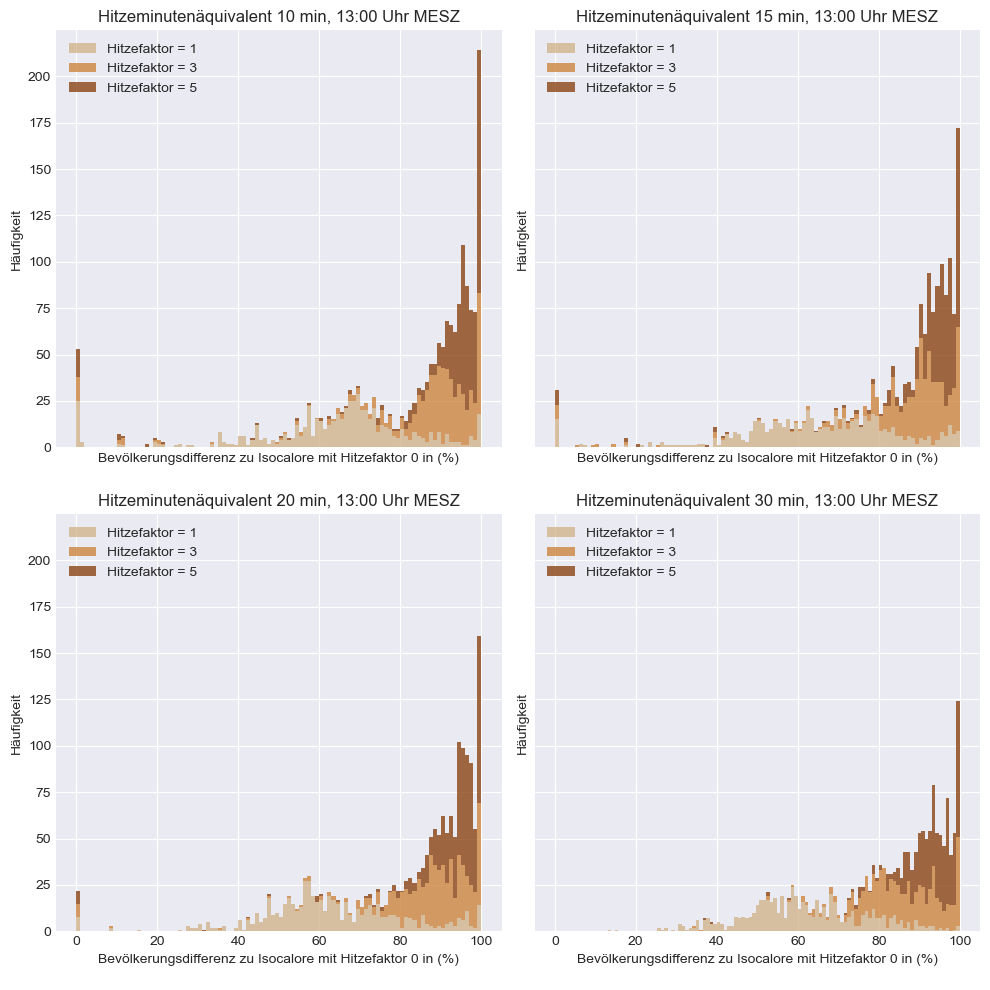

In [30]:
# Filter the data for 'noon' time of day
isochrones_df_pop_noon = isochrones_df_pop[isochrones_df_pop['timeofday'] == 'noon']

# Define the shadow factors and values to filter
shadow_factors = [1.0, 3.0, 5.0]
values = [900, 600, 300, 1800, 1200]

# Create a dictionary to store the filtered data
filtered_data = {
    (sf, val): isochrones_df_pop_noon[(isochrones_df_pop_noon['shadow_factor'] == sf) & 
                                      (isochrones_df_pop_noon['value'] == val)]['pop_diff_perc']
    for sf in shadow_factors for val in values
}

# Prepare data for plotting
data_for_plotting = {val: [filtered_data[(sf, val)] for sf in shadow_factors] for val in values}

# Plotting
fig, axs = plt.subplots(2, 2, figsize=(10, 10), sharex=True, sharey=True)
colors = ['tan', 'peru', 'saddlebrown']
labels = ['Hitzefaktor = 1', 'Hitzefaktor = 3', 'Hitzefaktor = 5']

# Define the titles for the subplots
titles = {
    600: 'Hitzeminutenäquivalent 10 min, 13:00 Uhr MESZ',
    900: 'Hitzeminutenäquivalent 15 min, 13:00 Uhr MESZ',
    1200: 'Hitzeminutenäquivalent 20 min, 13:00 Uhr MESZ',
    1800: 'Hitzeminutenäquivalent 30 min, 13:00 Uhr MESZ'
}

# Map the values to subplot positions
subplot_positions = {
    600: (0, 0),
    900: (0, 1),
    1200: (1, 0),
    1800: (1, 1)
}

# Plot each histogram
for val, pos in subplot_positions.items():
    axs[pos].hist(data_for_plotting[val], bins=100, alpha=0.8, stacked=True, color=colors, label=labels)
    axs[pos].set_xlabel('Bevölkerungsdifferenz zu Isocalore mit Hitzefaktor 0 in (%)\n')
    axs[pos].set_ylabel('Häufigkeit')
    axs[pos].set_title(titles[val])
    axs[pos].legend(loc='upper left')

# Set the layout
plt.style.use('seaborn-darkgrid')
# plt.suptitle('Histogramme der Differenz der Anzahl der Bevölkerung in Isocaloren nach Hitzeminutenäquivalenten, 13:00 Uhr MESZ\n', fontsize=16)
plt.tight_layout()

# Save and display the plot
plt.savefig(f'{Path.cwd()}\data\\pop_diff_histogram_{pois_name}_heal_10_15_20_30_noon.png')
plt.show()

Plot the mean area difference by shadow_factor

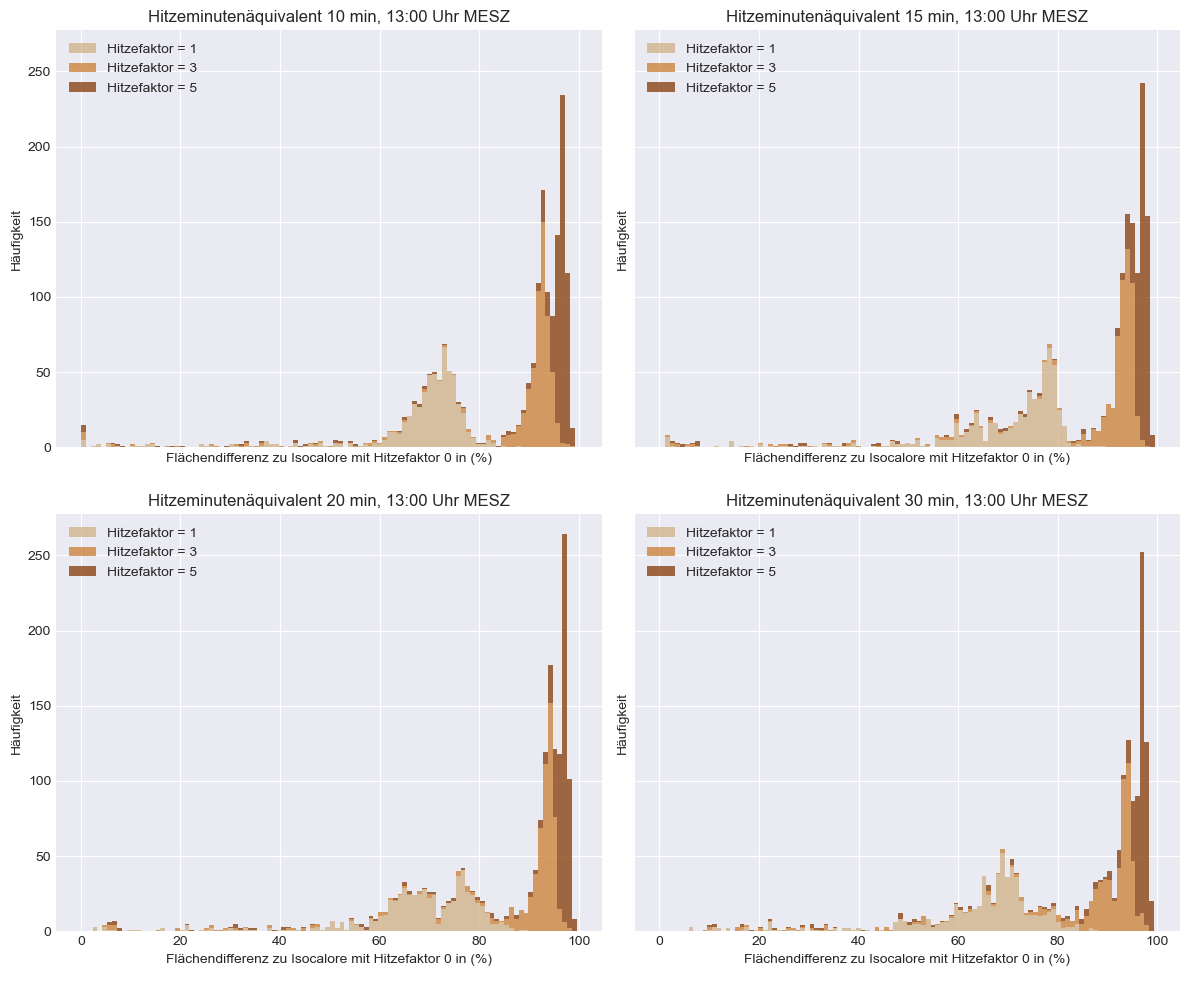

In [31]:
# Filter the data for 'noon' time of day
isochrones_df_area_noon = isochrones_df_area[isochrones_df_area['timeofday'] == 'noon']

# Define the shadow factors and values to filter
shadow_factors = [1.0, 3.0, 5.0]
values = [900, 600, 300, 1800, 1200]

# Create a dictionary to store the filtered data
filtered_data = {
    (sf, val): isochrones_df_area_noon[(isochrones_df_area_noon['shadow_factor'] == sf) & 
                                      (isochrones_df_area_noon['value'] == val)]['area_diff_perc']
    for sf in shadow_factors for val in values
}

# Prepare data for plotting
data_for_plotting = {val: [filtered_data[(sf, val)] for sf in shadow_factors] for val in values}

# Plotting
fig, axs = plt.subplots(2, 2, figsize=(12, 10), sharex=True, sharey=True)
colors = ['tan', 'peru', 'saddlebrown']
labels = ['Hitzefaktor = 1', 'Hitzefaktor = 3', 'Hitzefaktor = 5']

# Define the titles for the subplots
titles = {
    600: 'Hitzeminutenäquivalent 10 min, 13:00 Uhr MESZ',
    900: 'Hitzeminutenäquivalent 15 min, 13:00 Uhr MESZ',
    1200: 'Hitzeminutenäquivalent 20 min, 13:00 Uhr MESZ',
    1800: 'Hitzeminutenäquivalent 30 min, 13:00 Uhr MESZ'
}

# Map the values to subplot positions
subplot_positions = {
    600: (0, 0),
    900: (0, 1),
    1200: (1, 0),
    1800: (1, 1)
}

# Plot each histogram
for val, pos in subplot_positions.items():
    axs[pos].hist(data_for_plotting[val], bins=100, alpha=0.8, stacked=True, color=colors, label=labels)
    axs[pos].set_xlabel('Flächendifferenz zu Isocalore mit Hitzefaktor 0 in (%)\n')
    axs[pos].set_ylabel('Häufigkeit')
    axs[pos].set_title(titles[val])
    axs[pos].legend(loc='upper left')

plt.style.use('seaborn-v0_8-darkgrid')
# plt.suptitle('Histogramme der Differenz der Fläche in Isocaloren nach Hitzeminutenäquivalenten, 13:00 Uhr MESZ\n', fontsize=16)
plt.tight_layout()

# Save and display the plot
plt.savefig(f'{Path.cwd()}\data\\area_diff_histogram_{pois_name}_heal_10_15_20_30_noon.png')
plt.show()

Plot the population difference by City Quarter

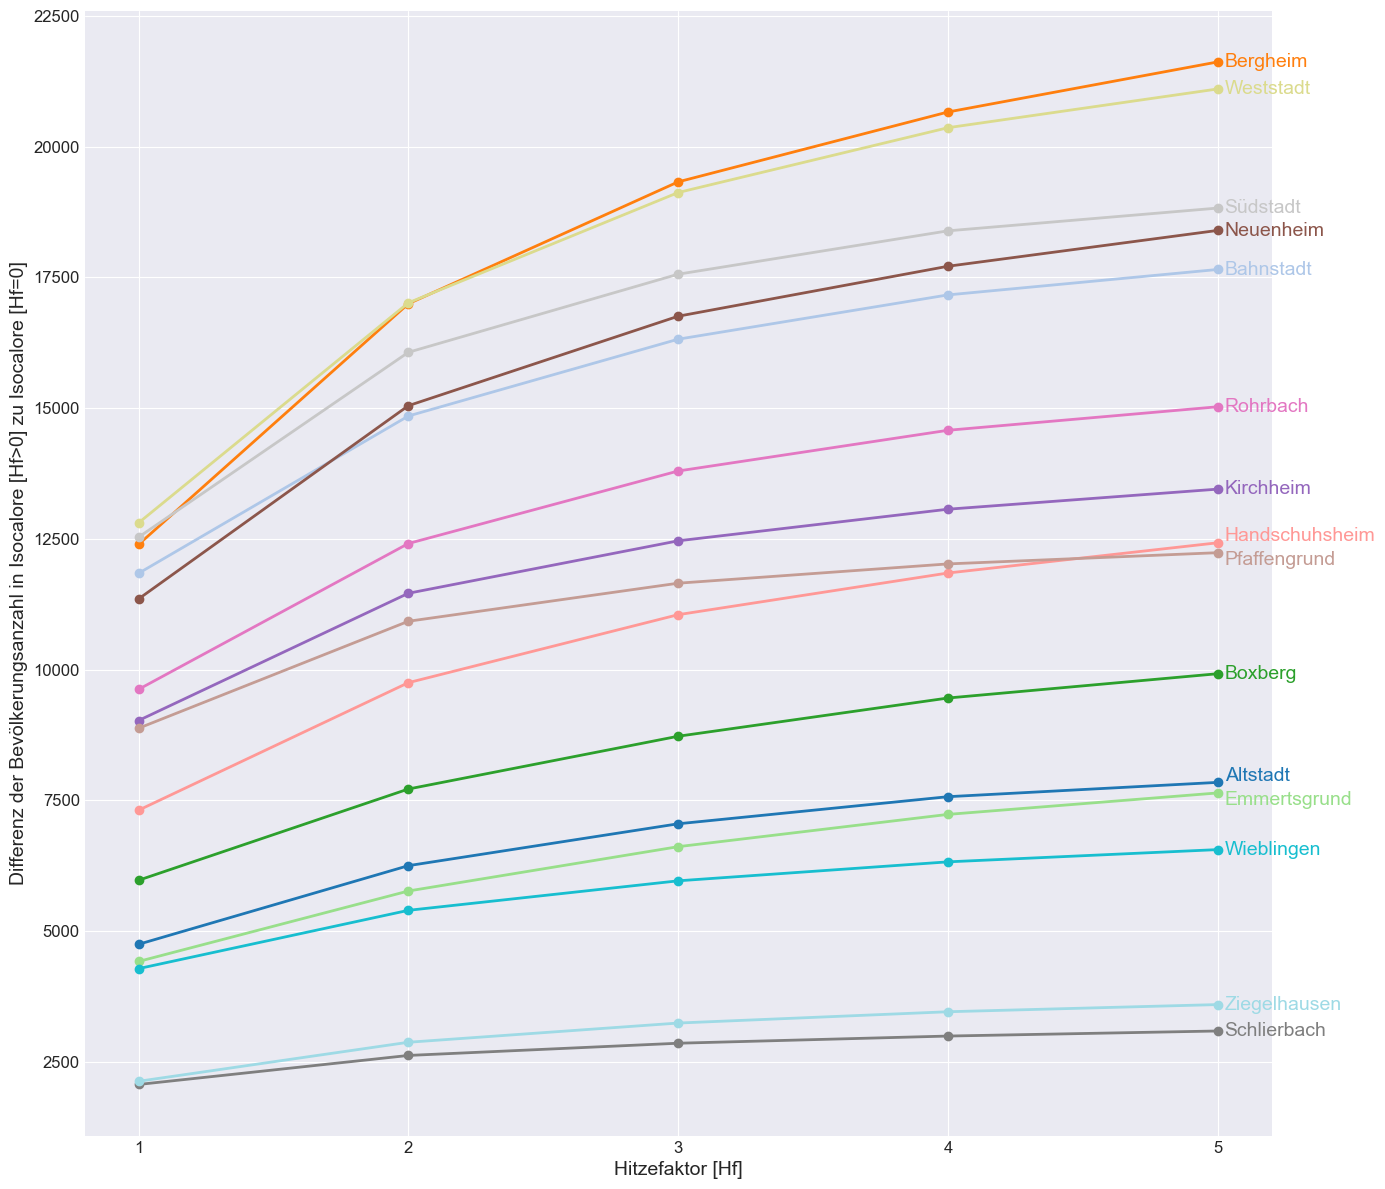

In [32]:
# Group the isochrones by quarter
isochrones_df_quarters = isochrones_df_pop.groupby('quarter')

# Create a figure and axes
fig, ax = plt.subplots(figsize=(14, 12))

# Get the number of quarters
n_quarters = len(isochrones_df_quarters)

# Define a color palette
color_palette = plt.get_cmap("tab20", n_quarters)
colors = [color_palette(i) for i in range(n_quarters)]

# Create a dictionary to store the lines for the legend
lines = {}

for i, (quarter, group) in enumerate(isochrones_df_quarters):
    # Create a new GeoDataFrame for the current quarter
    isochrones_df_quarter = group

    # Extract the values for x and y coordinates
    mean_pop_diff = isochrones_df_quarter.groupby('shadow_factor')['pop_difference'].mean() # can be 'pop_difference' and 'pop_diff_perc'
    
    # Plot the line with a distinct color
    line = ax.plot(mean_pop_diff.index, mean_pop_diff.values, label=quarter, 
                   color=colors[i], marker='o', linewidth=2, markersize=6)
    
    # Store the line for the legend
    lines[quarter] = line[0]
    
    # Add text label at the end of each line
    last_x = mean_pop_diff.index[-1]
    last_y = mean_pop_diff.values[-1]
      
    # Determine the vertical offset based on the label
    if quarter in ['Handschuhsheim', 'Altstadt']:
        offset_y = 5  # Move these labels up
    elif quarter in ['Emmertsgrund', 'Pfaffengrund']:
        offset_y = -5  # Move these labels down
    else:
        offset_y = 0  # Centered for all other labels
    
    ax.annotate(quarter, (last_x, last_y), xytext=(5, offset_y), 
                textcoords='offset points', ha='left', va='center',
                fontsize=14, color=colors[i]) 

# Set the title and labels
# ax.set_title('Differenz der Anzahl der Bevölkerung nach Hitzefaktor pro Stadtteil', fontsize=16)
ax.set_xlabel('Hitzefaktor [Hf]', fontsize=14)
ax.set_ylabel('Differenz der Bevölkerungsanzahl in Isocalore [Hf>0] zu Isocalore [Hf=0]', fontsize=14)

# Customize the tick labels
ax.tick_params(axis='both', which='major', labelsize=12)

# Set x-ticks to show only integer values
ax.set_xticks(np.arange(int(min(mean_pop_diff.index)), int(max(mean_pop_diff.index)) + 1))

# Adjust layout and style
plt.style.use('seaborn-v0_8-darkgrid')
plt.tight_layout()

# Save and display the plot
plt.savefig(f'{Path.cwd()}\data\\pop_diff_quarters_mean_{pois_name}_heal_10_15_20_30_noon.png')
plt.show()